# Maximum Clique Finding - Comparative Analysis

This notebook explores and compares different algorithms for finding maximum cliques in random graphs:
1. **Brute Force** - Exhaustive search approach
2. **Binary Search** - Optimized brute force using binary search
3. **Greedy Heuristic** - Fast approximation algorithm
4. **Tomita Algorithm** - State-of-the-art exact algorithm with pivoting
5. **K-Core Pruning** - Graph reduction technique

We'll analyze their performance across varying graph densities and sizes.

In [268]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import deque
import random
import time

random.seed(42)

## 2. Helper Function: K-Clique Detection

Recursive function to check if a k-clique exists in the graph.

In [ ]:
def has_clique(vertices, edges, k):
    if k == 0:
        return True
    
    if len(vertices) < k:
        return False
    
    u = next(iter(vertices))
    
    # Case 1: u IS in the k-clique
    neighbors_of_u = set()
    for v in vertices:
        if u == v:
            continue
        edge = (min(u, v), max(u, v))
        if edge in edges:
            neighbors_of_u.add(v)
    
    if has_clique(neighbors_of_u, edges, k - 1):
        return True
    
    # Case 2: u IS NOT in the k-clique
    vertices_without_u = vertices.copy()
    vertices_without_u.remove(u)
    
    if has_clique(vertices_without_u, edges, k):
        return True
    
    return False

## 3. Graph Class

The `Graph` class creates random graphs and implements brute force, binary search, greedy, and k-core algorithms.

In [270]:
class Graph:
    def __init__(self, num_vertices, density=0.5):
        self.num_vertices = num_vertices
        self.degree_set = np.zeros(num_vertices)
        self.graph_density = density

    def construct_graph(self):
        """Generate a random graph with specified density."""
        self.graph = set()
        for start in range(self.num_vertices):
            for end in range(start + 1, self.num_vertices):
                if random.uniform(0, 1) > 1 - self.graph_density:
                    self.graph.add((start, end))
                    self.degree_set[start] += 1
                    self.degree_set[end] += 1
        return self.graph
    
    def brute_force_k_clique(self, k):
        """Check if a k-clique exists using brute force."""
        all_vertices = set(range(self.num_vertices))
        return has_clique(all_vertices, self.graph, k)
    
    def brute_force_max_clique(self):
        """Find maximum clique size by testing from n down to 1."""
        n = self.num_vertices
        all_vertices = set(range(n))
        for i in range(n, 0, -1):
            if has_clique(all_vertices, self.graph, i):
                return i
        return 0
    
    def binary_search_max_clique(self):
        """Find maximum clique size using binary search optimization."""
        n = self.num_vertices
        all_vertices = set(range(n))
        low, high = 0, n
        max_k_found = 0
        
        while low <= high:
            mid = (low + high) // 2
            if has_clique(all_vertices, self.graph, mid):
                max_k_found = mid
                low = mid + 1
            else:
                high = mid - 1
        
        return max_k_found
    
    def greedy_clique(self):
        """Find a clique greedily by sorting vertices by degree."""
        sorted_vertices = sorted(range(self.num_vertices), 
                                key=lambda v: self.degree_set[v], reverse=True)
        clique = set()
        remaining_vertices = set(sorted_vertices)
        
        for v in sorted_vertices:
            if v in remaining_vertices:
                # Check if adding v maintains clique property
                can_add = all((min(v, c), max(v, c)) in self.graph for c in clique)
                
                if can_add:
                    clique.add(v)
                    # Remove vertices not connected to the newly added vertex
                    to_remove = {r for r in remaining_vertices 
                                if r != v and (min(v, r), max(v, r)) not in self.graph}
                    remaining_vertices -= to_remove
        
        return len(clique)
    
    def k_core(self, k):
        """Find k-core of the graph (vertices with degree >= k) using deque for efficiency."""
        vertices = set(range(self.num_vertices))
        degrees = self.degree_set.copy()
        queue = deque([v for v in vertices if degrees[v] < k])
        
        while queue:
            v = queue.popleft()  # Use popleft() for O(1) operation
            if v in vertices:
                vertices.remove(v)
                # Decrease degree of neighbors
                for u in range(self.num_vertices):
                    if u in vertices and (min(v, u), max(v, u)) in self.graph:
                        degrees[u] -= 1
                        if degrees[u] < k:
                            queue.append(u)
        
        return vertices

## 4. Tomita Algorithm (Bron-Kerbosch with Pivoting)

Uses pivot selection to efficiently find the maximum clique.

In [ ]:
class TomitaGraph(Graph):
    def __init__(self, num_vertices, density=0.5):
        super().__init__(num_vertices, density)
        self.graph = self.construct_graph()
        self.construct_neighbors()

    def construct_neighbors(self):
        neighbor_graph = [set() for _ in range(self.num_vertices)]
        for u, v in self.graph:
            neighbor_graph[u].add(v)
            neighbor_graph[v].add(u)
        self.neighbor_graph = neighbor_graph

    def tomita_algo(self, R, P, X):
        if not P and not X:
            if len(R) > len(self.max_clique):
                self.max_clique = R.copy()
            return

        if not P:
            return

        pivot_candidates = P | X
        pivot_element = max(pivot_candidates, key=lambda i: len(self.neighbor_graph[i] & P))
        candidates_to_check = list(P - self.neighbor_graph[pivot_element])

        for candidate in candidates_to_check:
            neighbors = self.neighbor_graph[candidate]
            self.tomita_algo(R | {candidate}, P & neighbors, X & neighbors)
            P.remove(candidate)
            X.add(candidate)

    def find_max_clique(self):
        self.max_clique = set()
        self.tomita_algo(set(), set(range(self.num_vertices)), set())
        return list(self.max_clique)
    
    def bk_pivot_algo(self, R, P, X):
        """Bron-Kerbosch with pivot - simpler pivot selection (first element)."""
        if not P and not X:
            if len(R) > len(self.max_clique):
                self.max_clique = R.copy()
            return

        if not P:
            return

        # Choose pivot from P ∪ X (just pick the first one, simpler than Tomita)
        pivot_candidates = P | X
        pivot = next(iter(pivot_candidates))  # Simple selection, not using max like Tomita
        
        # Iterate over P \ N(pivot)
        for v in list(P - self.neighbor_graph[pivot]):
            neighbors = self.neighbor_graph[v]
            self.bk_pivot_algo(R | {v}, P & neighbors, X & neighbors)
            P.remove(v)
            X.add(v)
    
    def find_max_clique_bk_pivot(self):
        """Find maximum clique using Bron-Kerbosch with pivot."""
        self.max_clique = set()
        self.bk_pivot_algo(set(), set(range(self.num_vertices)), set())
        return list(self.max_clique)
    
    def bk_simple_algo(self, R, P, X):
        """Simple Bron-Kerbosch without pivot - most basic version."""
        if not P and not X:
            if len(R) > len(self.max_clique):
                self.max_clique = R.copy()
            return

        # No pivot - iterate over all vertices in P
        for v in list(P):
            neighbors = self.neighbor_graph[v]
            self.bk_simple_algo(R | {v}, P & neighbors, X & neighbors)
            P.remove(v)
            X.add(v)
    
    def find_max_clique_bk_simple(self):
        self.max_clique = set()
        self.bk_simple_algo(set(), set(range(self.num_vertices)), set())
        return list(self.max_clique)
    
    def find_max_clique_with_pruning(self):
        """Find max clique using K-Core pruning + Tomita algorithm."""
        # Step 1: Get greedy lower bound
        lower_bound = self.greedy_clique()
        
        # Step 2: Prune using k-core (k = lower_bound - 1)
        k_prune = max(0, lower_bound - 1)
        pruned_vertices = self.k_core(k_prune)
        
        if len(pruned_vertices) == 0:
            return lower_bound
        
        # Step 3: Run Tomita only on pruned vertices
        self.max_clique = set()
        self.tomita_algo(set(), pruned_vertices, set())
        
        return len(self.max_clique)

## 5. Performance Measurement

We'll measure how execution time varies with:
- **Graph density**: 0.1 to 0.9 (in steps of 0.1)
- **Number of vertices**: 5 to 40

In [272]:
def measure_clique_time(num_vertices, density):
    """Measure time taken to find max clique in a graph."""
    graph = TomitaGraph(num_vertices, density)
    start_time = time.time()
    graph.find_max_clique()
    end_time = time.time()
    return end_time - start_time

In [273]:
# Measure execution times for different densities and vertex counts
density_execution_times = {}
densities = np.arange(0.1, 1.0, 0.1)

for density in densities:
    vertex_counts = []
    execution_times = []
    
    for num_vertices in range(5, 40):
        time_taken = measure_clique_time(num_vertices, density)
        execution_times.append(time_taken)
        vertex_counts.append(num_vertices)
    
    density_execution_times[density] = (vertex_counts, execution_times)

## 6. Observations

- **Exponential growth**: Execution time increases exponentially with the number of vertices
- **Density impact**: Higher density graphs take longer to process
- **Practical limit**: The algorithm is practical for graphs up to ~40 vertices with high density

## 7. Algorithm Comparison

Compare all algorithms side-by-side on graphs of varying sizes.

In [275]:
def measure_algorithm(graph, algorithm_name):
    """Measure execution time for a specific algorithm."""
    start_time = time.time()
    
    # Normalize algorithm name to handle both formats
    alg = algorithm_name.lower().replace(' ', '_').replace('-', '_').replace('+', '').replace('__', '_')
    
    if alg == "brute_force":
        result = graph.brute_force_max_clique()
    elif alg == "binary":
        result = graph.binary_search_max_clique()
    elif alg == "greedy":
        result = graph.greedy_clique()
    elif alg == "tomita":
        tomita_graph = TomitaGraph.__new__(TomitaGraph)
        tomita_graph.num_vertices = graph.num_vertices
        tomita_graph.graph = graph.graph
        tomita_graph.degree_set = graph.degree_set
        tomita_graph.graph_density = graph.graph_density
        tomita_graph.construct_neighbors()
        result = len(tomita_graph.find_max_clique())
    elif alg == "bk_pivot":
        tomita_graph = TomitaGraph.__new__(TomitaGraph)
        tomita_graph.num_vertices = graph.num_vertices
        tomita_graph.graph = graph.graph
        tomita_graph.degree_set = graph.degree_set
        tomita_graph.graph_density = graph.graph_density
        tomita_graph.construct_neighbors()
        result = len(tomita_graph.find_max_clique_bk_pivot())
    elif alg == "bk_simple":
        tomita_graph = TomitaGraph.__new__(TomitaGraph)
        tomita_graph.num_vertices = graph.num_vertices
        tomita_graph.graph = graph.graph
        tomita_graph.degree_set = graph.degree_set
        tomita_graph.graph_density = graph.graph_density
        tomita_graph.construct_neighbors()
        result = len(tomita_graph.find_max_clique_bk_simple())
    elif alg == "k_core_tomita":
        tomita_graph = TomitaGraph.__new__(TomitaGraph)
        tomita_graph.num_vertices = graph.num_vertices
        tomita_graph.graph = graph.graph
        tomita_graph.degree_set = graph.degree_set.copy()
        tomita_graph.graph_density = graph.graph_density
        tomita_graph.construct_neighbors()
        result = tomita_graph.find_max_clique_with_pruning()
    else:
        raise ValueError(f"Unknown algorithm: {algorithm_name}")
    
    end_time = time.time()
    return result, end_time - start_time

### 7.1 Comparison Across Different Graph Sizes

Compare all algorithms on graphs with increasing number of vertices (fixed density = 0.5).

In [308]:
# Compare algorithms across different graph sizes (5 runs per vertex count, averaged)
algorithms = ["greedy", "binary", "brute_force","tomita", "bk_simple", "bk_pivot", "k_core_tomita"]
vertex_range = range(5, 51)  # Up to 50 vertices
density = 0.5
NUM_RUNS = 5  # Number of graphs to generate per vertex count

algorithm_times = {alg: [] for alg in algorithms}
vertex_list = list(vertex_range)

print(f"Running algorithm comparison with {NUM_RUNS} runs per vertex count...")
print(f"Testing vertices from 5 to 50 with density = {density}")
print("=" * 60)

for num_vertices in vertex_range:
    # Store times for each run
    run_times = {alg: [] for alg in algorithms}
    
    for run in range(NUM_RUNS):
        # Create a new random graph for each run
        graph = Graph(num_vertices, density)
        graph.construct_graph()
        
        for alg in algorithms:
            _, time_taken = measure_algorithm(graph, alg)
            run_times[alg].append(time_taken)
    
    # Calculate average time for each algorithm
    for alg in algorithms:
        avg_time = np.mean(run_times[alg])
        algorithm_times[alg].append(avg_time)
    
    if num_vertices % 5 == 0:
        print(f"Completed: {num_vertices} vertices (avg of {NUM_RUNS} runs)")

print("=" * 60)
print("Done!")

Running algorithm comparison with 5 runs per vertex count...
Testing vertices from 5 to 50 with density = 0.5
Completed: 5 vertices (avg of 5 runs)
Completed: 10 vertices (avg of 5 runs)
Completed: 15 vertices (avg of 5 runs)
Completed: 20 vertices (avg of 5 runs)
Completed: 25 vertices (avg of 5 runs)
Completed: 25 vertices (avg of 5 runs)
Completed: 30 vertices (avg of 5 runs)
Completed: 30 vertices (avg of 5 runs)
Completed: 35 vertices (avg of 5 runs)
Completed: 35 vertices (avg of 5 runs)
Completed: 40 vertices (avg of 5 runs)
Completed: 40 vertices (avg of 5 runs)
Completed: 45 vertices (avg of 5 runs)
Completed: 45 vertices (avg of 5 runs)
Completed: 50 vertices (avg of 5 runs)
Done!
Completed: 50 vertices (avg of 5 runs)
Done!


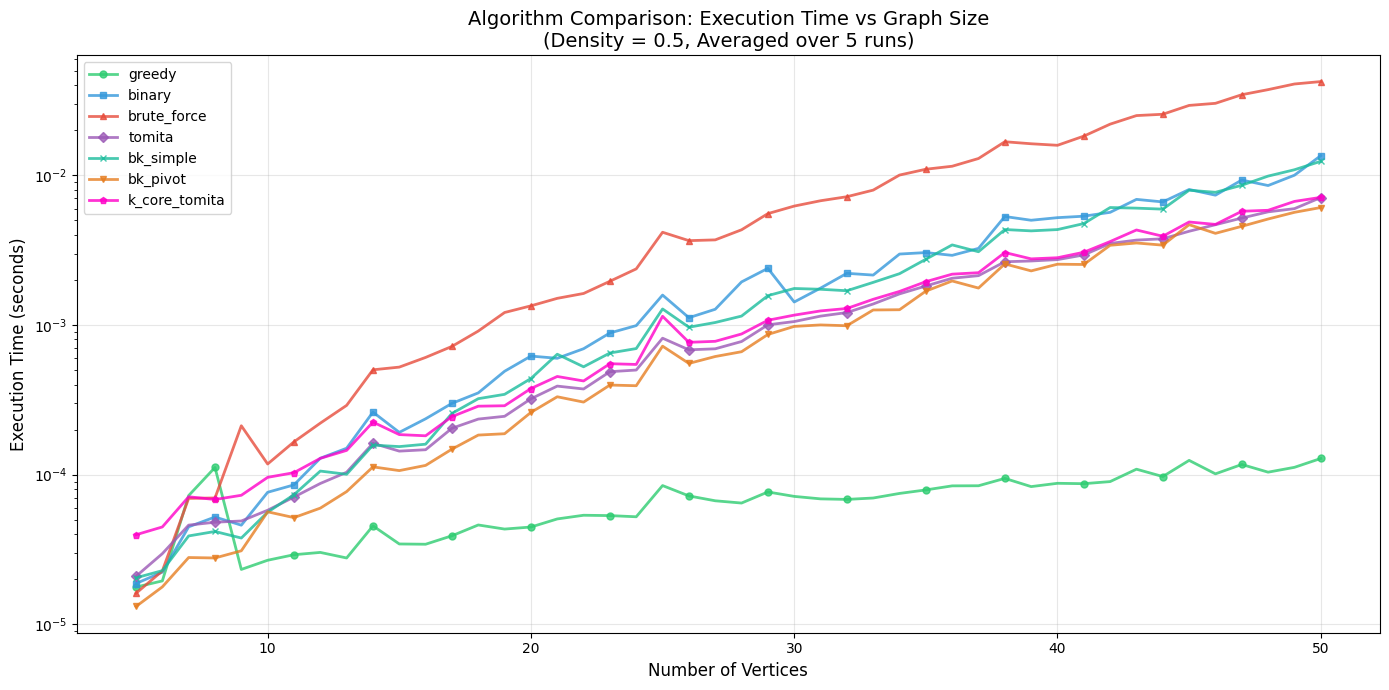

In [309]:
# Plot: All algorithms comparison across graph sizes (averaged over 5 runs)
fig, ax = plt.subplots(figsize=(14, 7))

colors = {'greedy': '#2ecc71', 'binary': '#3498db', 'brute_force': '#e74c3c', 
          'tomita': '#9b59b6', 'bk_simple': '#1abc9c', 'bk_pivot': '#e67e22', 'k_core_tomita': "#ff00c8"}
markers = {'greedy': 'o', 'binary': 's', 'brute_force': '^', 
           'tomita': 'D', 'bk_simple': 'x', 'bk_pivot': 'v', 'k_core_tomita': 'p'}

for alg in algorithms:
    ax.plot(vertex_list, algorithm_times[alg], 
            label=alg, color=colors[alg], marker=markers[alg], 
            linewidth=2, markersize=5, alpha=0.8, markevery=3)

ax.set_xlabel("Number of Vertices", fontsize=12)
ax.set_ylabel("Execution Time (seconds)", fontsize=12)
ax.set_title(f"Algorithm Comparison: Execution Time vs Graph Size\n(Density = {density}, Averaged over {NUM_RUNS} runs)", fontsize=14)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

plt.tight_layout()
plt.show()

### 7.2 Single Graph Comparison (Bar Chart)

Side-by-side bar chart comparing all algorithms on a single graph.

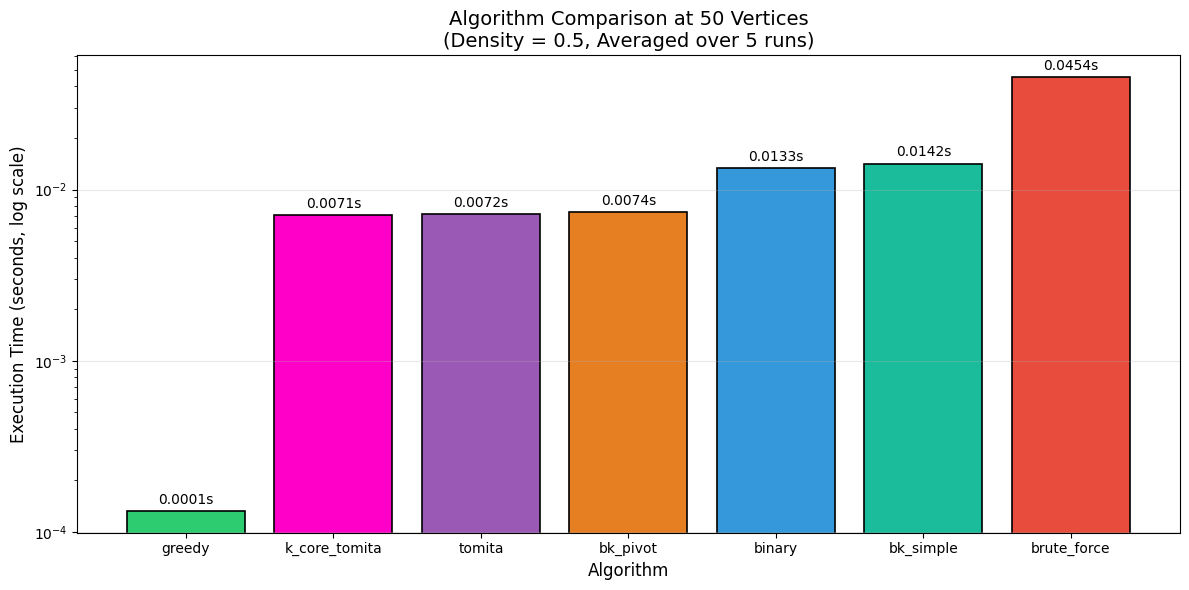

In [307]:
# Plot: Bar Chart Comparison at largest size (50 vertices, averaged over 5 runs)
largest_size_idx = -1  # Index for the largest graph size (50 vertices)
final_times = {alg: algorithm_times[alg][largest_size_idx] for alg in algorithms}

# Sort algorithms by execution time for clearer comparison
sorted_algs = sorted(final_times.items(), key=lambda x: x[1])
alg_names = [alg for alg, _ in sorted_algs]
times = [time for _, time in sorted_algs]

fig, ax = plt.subplots(figsize=(12, 6))

bars = ax.bar(alg_names, times, color=[colors[alg] for alg in alg_names], edgecolor='black', linewidth=1.2)
ax.set_ylabel("Execution Time (seconds, log scale)", fontsize=12)
ax.set_xlabel("Algorithm", fontsize=12)
ax.set_title(f"Algorithm Comparison at {vertex_list[-1]} Vertices\n(Density = {density}, Averaged over {NUM_RUNS} runs)", fontsize=14)
ax.set_yscale('log')
ax.grid(True, alpha=0.3, axis='y')

# Add time labels on bars
for bar, t in zip(bars, times):
    ax.annotate(f'{t:.4f}s', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

### 7.3 Comparison Across Different Densities

How does each algorithm perform as graph density changes?

In [279]:
# 8.3 Density Comparison (averaged over 5 runs)
densities = [0.2, 0.4, 0.6, 0.8]
fixed_vertices = 50
NUM_DENSITY_RUNS = 5

density_times = {alg: [] for alg in algorithms}

for d in densities:
    times_per_density = {alg: [] for alg in algorithms}
    
    for run in range(NUM_DENSITY_RUNS):
        random.seed(42 + run * 100 + int(d * 10))  # Different seed per run
        g = TomitaGraph(fixed_vertices, d)
        
        for alg in algorithms:
            _, t = measure_algorithm(g, alg)
            times_per_density[alg].append(t)
    
    # Average over runs
    for alg in algorithms:
        density_times[alg].append(sum(times_per_density[alg]) / NUM_DENSITY_RUNS)

print(f"Density comparison completed for {fixed_vertices} vertices (averaged over {NUM_DENSITY_RUNS} runs)")

Density comparison completed for 50 vertices (averaged over 5 runs)


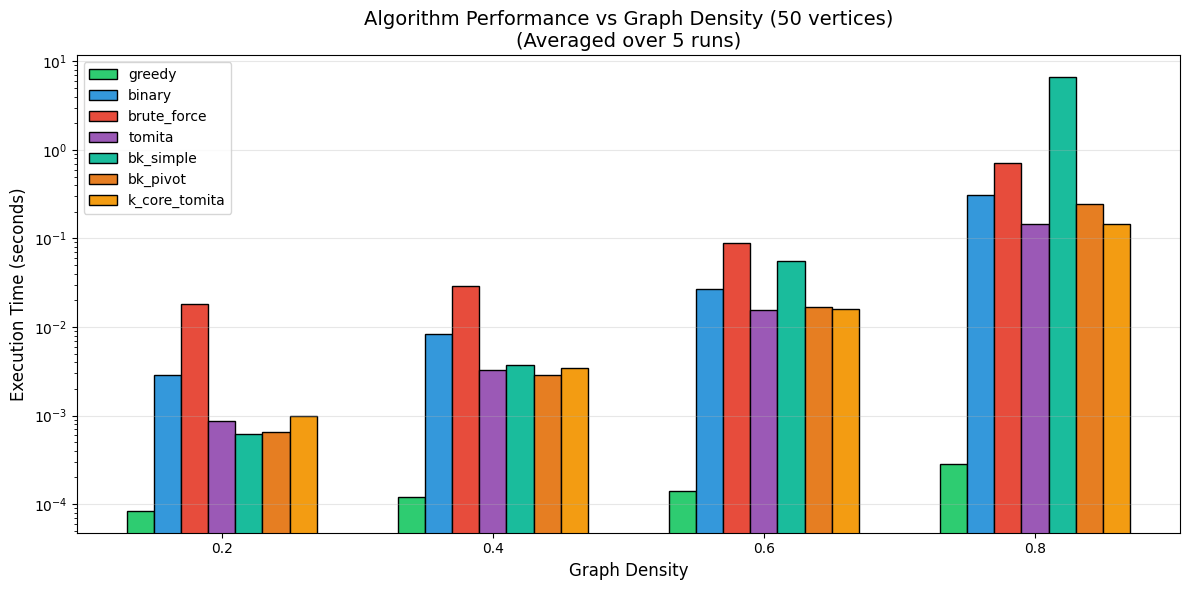

In [285]:
# Plot: Density Comparison (averaged over 5 runs)
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(densities))
width = 0.10

for i, alg in enumerate(algorithms):
    offset = (i - len(algorithms)/2 + 0.5) * width
    bars = ax.bar(x + offset, density_times[alg], width, label=alg, color=colors[alg], edgecolor='black')

ax.set_xlabel("Graph Density", fontsize=12)
ax.set_ylabel("Execution Time (seconds)", fontsize=12)
ax.set_title(f"Algorithm Performance vs Graph Density ({fixed_vertices} vertices)\n(Averaged over {NUM_DENSITY_RUNS} runs)", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels([f"{d:.1f}" for d in densities])
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
ax.set_yscale('log')

plt.tight_layout()
plt.show()

### 7.4 Heatmap: Time Complexity Overview

Visualize execution time for each algorithm across both vertices and densities.

In [281]:
# 8.4 Heatmap of Algorithm Performance (averaged over 5 runs)
# Create performance matrix for different vertex counts and algorithms
heatmap_vertices = [10, 15, 20, 25, 30, 35, 40, 45, 50]
heatmap_density = 0.5
NUM_HEATMAP_RUNS = 5

performance_matrix = []
for v in heatmap_vertices:
    times_per_row = {alg: [] for alg in algorithms}
    
    for run in range(NUM_HEATMAP_RUNS):
        random.seed(42 + v + run * 50)  # Different seed per run
        g = TomitaGraph(v, heatmap_density)
        
        for alg in algorithms:
            _, t = measure_algorithm(g, alg)
            times_per_row[alg].append(t)
    
    # Average over runs
    row = [sum(times_per_row[alg]) / NUM_HEATMAP_RUNS for alg in algorithms]
    performance_matrix.append(row)

print(f"Heatmap data computed (averaged over {NUM_HEATMAP_RUNS} runs)")

Heatmap data computed (averaged over 5 runs)


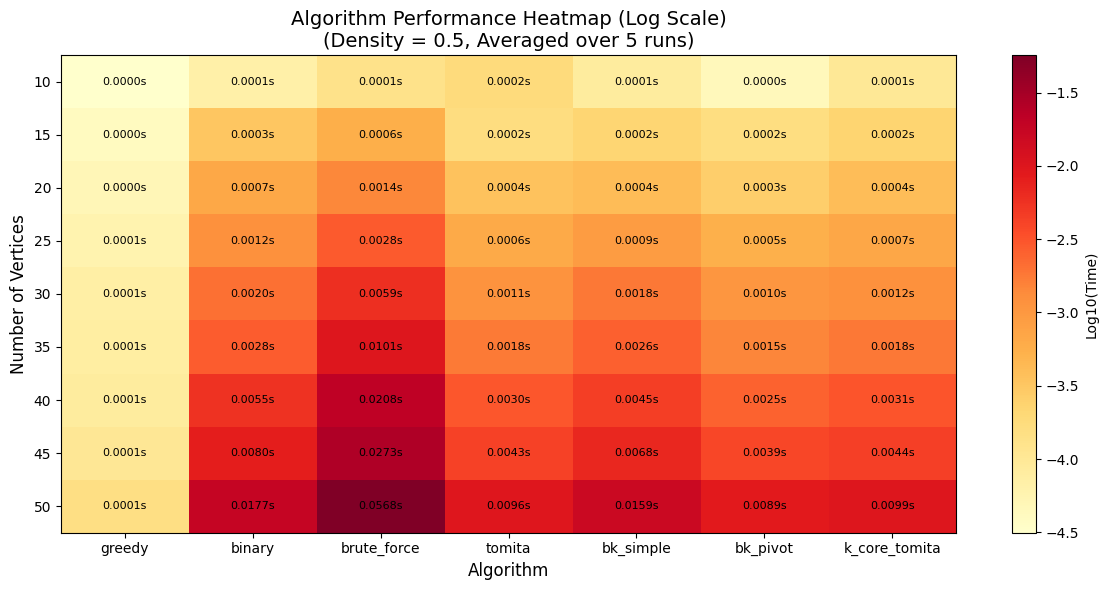

In [282]:
# Plot: Heatmap (averaged over 5 runs)
fig, ax = plt.subplots(figsize=(12, 6))

im = ax.imshow(np.log10(np.array(performance_matrix) + 1e-6), cmap='YlOrRd', aspect='auto')

ax.set_xticks(np.arange(len(algorithms)))
ax.set_yticks(np.arange(len(heatmap_vertices)))
ax.set_xticklabels(algorithms, fontsize=10)
ax.set_yticklabels(heatmap_vertices, fontsize=10)

ax.set_xlabel("Algorithm", fontsize=12)
ax.set_ylabel("Number of Vertices", fontsize=12)
ax.set_title(f"Algorithm Performance Heatmap (Log Scale)\n(Density = {heatmap_density}, Averaged over {NUM_HEATMAP_RUNS} runs)", fontsize=14)

# Add text annotations
for i in range(len(heatmap_vertices)):
    for j in range(len(algorithms)):
        text = ax.text(j, i, f"{performance_matrix[i][j]:.4f}s",
                       ha="center", va="center", color="black", fontsize=8)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Log10(Time)', fontsize=10)

plt.tight_layout()
plt.show()

## 8. Summary

### Key Findings:

| Algorithm | Time Complexity | Exact? | Best For |
|-----------|----------------|--------|----------|
| **Greedy** | O(V²) | No (approx) | Fast approximation, large graphs |
| **Binary Search** | O(log V · V^(V+2)) | Yes | Medium graphs |
| **Brute Force** | O(V^(V+3)) | Yes | Small graphs only (~15 vertices) |
| **Tomita** | O(3^(V/3)) | Yes | Best exact algorithm (optimal pivot selection) |
| **BK Simple** | O(3^(V/3)) | Yes | Basic Bron-Kerbosch (no pivot) |
| **BK Pivot** | O(3^(V/3)) | Yes | Bron-Kerbosch with simple pivot |
| **K-Core + Tomita** | O(3^(V'/3)) | Yes | Optimized Tomita with pruning |

### Observations:
- **Greedy** is consistently the fastest but may not find the optimal clique
- **Tomita** uses smart pivot selection (max neighbors) for optimal performance
- **BK Simple** has no pivot selection - slowest of the Bron-Kerbosch variants
- **BK Pivot** uses simple pivot selection (first element) - faster than BK Simple, slower than Tomita
- **K-Core + Tomita** can be faster than plain Tomita by reducing the search space
- **Brute Force** becomes impractical beyond ~18 vertices
- **Graph density** significantly impacts execution time for all algorithms
- All exact algorithms produce the same results

## 9. Algorithm Correctness Verification

Let's verify that all exact algorithms produce the same (correct) results, and check how close greedy approximation is.

In [283]:
# Verify correctness of all algorithms with more test cases
all_algorithms = ["greedy", "binary", "brute_force", "tomita", "bk_simple", "bk_pivot", "k_core_tomita"]
fast_algorithms = ["greedy", "tomita", "bk_simple", "bk_pivot", "k_core_tomita"]

# Small graphs - test all algorithms
test_cases_small = [
    (8, 0.3), (8, 0.5), (8, 0.7),
    (10, 0.3), (10, 0.5), (10, 0.7),
    (12, 0.3), (12, 0.5), (12, 0.7),
    (15, 0.3), (15, 0.5), (15, 0.7),
    (18, 0.4), (18, 0.5), (18, 0.6),
]

# Larger graphs - test fast algorithms only
test_cases_large = [
    (25, 0.3), (25, 0.5), (25, 0.7),
    (30, 0.3), (30, 0.5), (30, 0.7),
    (35, 0.4), (35, 0.5), (35, 0.6),
    (40, 0.3), (40, 0.5), (40, 0.7),
    (45, 0.4), (45, 0.5), (45, 0.6),
    (50, 0.3), (50, 0.5), (50, 0.7),
]

print("=" * 100)
print("ALGORITHM CORRECTNESS VERIFICATION")
print("=" * 100)

# Part 1: Small graphs with all algorithms
print(f"\n{'='*100}")
print("PART 1: Small Graphs (All Algorithms)")
print(f"{'='*100}")
print(f"\n{'Vertices':<10} {'Density':<10} {'Greedy':<10} {'Binary':<10} {'BruteF':<10} {'Tomita':<10} {'BK-Sim':<10} {'BK-Piv':<10} {'K-Core':<10} {'Match?':<10}")
print("-" * 110)

all_correct = True
greedy_accuracy = []

for n_vert, dens in test_cases_small:
    graph = Graph(n_vert, dens)
    graph.construct_graph()
    
    results = {}
    for alg in all_algorithms:
        _, result = measure_algorithm(graph, alg)
        results[alg] = result
    
    # Exact algorithms should all match
    exact_results = [results["binary"], results["brute_force"], results["tomita"], 
                     results["bk_simple"], results["bk_pivot"], results["k_core_tomita"]]
    exact_match = len(set(exact_results)) == 1
    
    greedy_accuracy.append(results["greedy"] / exact_results[0] if exact_results[0] > 0 else 1)
    
    match_status = "✓ YES" if exact_match else "✗ NO"
    if not exact_match:
        all_correct = False
    
    print(f"{n_vert:<10} {dens:<10.1f} {results['greedy']:<10} {results['binary']:<10} {results['brute_force']:<10} {results['tomita']:<10} {results['bk_simple']:<10} {results['bk_pivot']:<10} {results['k_core_tomita']:<10} {match_status:<10}")

print("-" * 110)

# Part 2: Large graphs with fast algorithms only
print(f"\n{'='*100}")
print("PART 2: Large Graphs (Fast Algorithms Only)")
print(f"{'='*100}")
print(f"\n{'Vertices':<10} {'Density':<10} {'Greedy':<10} {'Tomita':<10} {'BK-Sim':<10} {'BK-Piv':<10} {'K-Core':<10} {'Match?':<10}")
print("-" * 90)

for n_vert, dens in test_cases_large:
    graph = Graph(n_vert, dens)
    graph.construct_graph()
    
    results = {}
    for alg in fast_algorithms:
        _, result = measure_algorithm(graph, alg)
        results[alg] = result
    
    # Check if all exact algorithms match
    exact_match = (results["tomita"] == results["bk_simple"] == results["bk_pivot"] == results["k_core_tomita"])
    greedy_accuracy.append(results["greedy"] / results["tomita"] if results["tomita"] > 0 else 1)
    
    match_status = "✓ YES" if exact_match else "✗ NO"
    if not exact_match:
        all_correct = False
    
    print(f"{n_vert:<10} {dens:<10.1f} {results['greedy']:<10} {results['tomita']:<10} {results['bk_simple']:<10} {results['bk_pivot']:<10} {results['k_core_tomita']:<10} {match_status:<10}")

print("-" * 90)
print(f"\n{'='*100}")
print("SUMMARY")
print(f"{'='*100}")
print(f"All exact algorithms match: {'✓ YES' if all_correct else '✗ NO'}")
print(f"Total test cases: {len(test_cases_small) + len(test_cases_large)}")
print(f"Greedy approximation ratio (avg): {np.mean(greedy_accuracy):.2%}")
print(f"Greedy approximation ratio (min): {min(greedy_accuracy):.2%}")
print(f"Greedy approximation ratio (max): {max(greedy_accuracy):.2%}")

ALGORITHM CORRECTNESS VERIFICATION

PART 1: Small Graphs (All Algorithms)

Vertices   Density    Greedy     Binary     BruteF     Tomita     BK-Sim     BK-Piv     K-Core     Match?    
--------------------------------------------------------------------------------------------------------------
8          0.3        8.0108642578125e-05 8.988380432128906e-05 0.0001468658447265625 5.555152893066406e-05 3.0040740966796875e-05 2.956390380859375e-05 9.846687316894531e-05 ✗ NO      
8          0.5        3.337860107421875e-05 6.961822509765625e-05 0.0001087188720703125 6.532669067382812e-05 5.8650970458984375e-05 3.218650817871094e-05 9.584426879882812e-05 ✗ NO      
8          0.7        4.410743713378906e-05 0.00011372566223144531 0.00013327598571777344 0.00011086463928222656 0.00011944770812988281 6.723403930664062e-05 0.00014448165893554688 ✗ NO      
10         0.3        3.743171691894531e-05 0.0024406909942626953 0.0002040863037109375 9.083747863769531e-05 7.271766662597656e-05 6.8426

### 9.1 Detailed Test with Clique Validation

Verify that the reported clique is actually a valid clique in the graph.

In [284]:
def is_valid_clique(clique_vertices, edges):
    """Check if the given set of vertices forms a valid clique."""
    clique_list = list(clique_vertices)
    for i in range(len(clique_list)):
        for j in range(i + 1, len(clique_list)):
            u, v = clique_list[i], clique_list[j]
            edge = (min(u, v), max(u, v))
            if edge not in edges:
                return False
    return True

# Detailed validation test with more test cases
print("=" * 80)
print("CLIQUE VALIDATION TEST")
print("=" * 80)

validation_tests = [
    (10, 0.4), (10, 0.6), 
    (15, 0.5), (15, 0.7),
    (20, 0.5), (20, 0.6),
    (25, 0.5), (25, 0.7),
    (30, 0.5), (30, 0.6),
    (40, 0.5), (40, 0.6),
    (50, 0.5), (50, 0.6),
]

all_valid = True
all_match = True

for n_vert, dens in validation_tests:
    print(f"\n--- Graph: {n_vert} vertices, density={dens} ---")
    
    # Create graph
    tomita_graph = TomitaGraph(n_vert, dens)
    
    # Get the actual clique (not just size)
    max_clique = tomita_graph.find_max_clique()
    
    # Validate it's a real clique
    is_valid = is_valid_clique(max_clique, tomita_graph.graph)
    if not is_valid:
        all_valid = False
    
    print(f"Max clique found: {sorted(max_clique)}")
    print(f"Clique size: {len(max_clique)}")
    print(f"Is valid clique: {'✓ YES' if is_valid else '✗ NO'}")
    
    # Compare with other algorithms (skip slow ones for large graphs)
    greedy_size = tomita_graph.greedy_clique()
    pruning_size = tomita_graph.find_max_clique_with_pruning()
    
    if n_vert <= 18:
        brute_force_size = tomita_graph.brute_force_max_clique()
        binary_search_size = tomita_graph.binary_search_max_clique()
        print(f"Sizes - Tomita: {len(max_clique)}, Brute Force: {brute_force_size}, "
              f"Binary Search: {binary_search_size}, Greedy: {greedy_size}, K-Core+Tomita: {pruning_size}")
        match = len(max_clique) == brute_force_size == binary_search_size == pruning_size
    else:
        print(f"Sizes - Tomita: {len(max_clique)}, Greedy: {greedy_size}, K-Core+Tomita: {pruning_size}")
        match = len(max_clique) == pruning_size
    
    if not match:
        all_match = False
    print(f"Exact algorithms agree: {'✓ YES' if match else '✗ NO'}")

print(f"\n{'='*80}")
print("VALIDATION SUMMARY")
print(f"{'='*80}")
print(f"All cliques valid: {'✓ YES' if all_valid else '✗ NO'}")
print(f"All exact algorithms agree: {'✓ YES' if all_match else '✗ NO'}")
print(f"Total validation tests: {len(validation_tests)}")

CLIQUE VALIDATION TEST

--- Graph: 10 vertices, density=0.4 ---
Max clique found: [0, 5, 7, 8]
Clique size: 4
Is valid clique: ✓ YES
Sizes - Tomita: 4, Brute Force: 4, Binary Search: 4, Greedy: 4, K-Core+Tomita: 4
Exact algorithms agree: ✓ YES

--- Graph: 10 vertices, density=0.6 ---
Max clique found: [0, 4, 6, 8]
Clique size: 4
Is valid clique: ✓ YES
Sizes - Tomita: 4, Brute Force: 4, Binary Search: 4, Greedy: 4, K-Core+Tomita: 4
Exact algorithms agree: ✓ YES

--- Graph: 15 vertices, density=0.5 ---
Max clique found: [2, 3, 5, 7, 10]
Clique size: 5
Is valid clique: ✓ YES
Sizes - Tomita: 5, Brute Force: 5, Binary Search: 5, Greedy: 5, K-Core+Tomita: 5
Exact algorithms agree: ✓ YES

--- Graph: 15 vertices, density=0.7 ---
Max clique found: [0, 4, 6, 8, 11, 13]
Clique size: 6
Is valid clique: ✓ YES
Sizes - Tomita: 6, Brute Force: 6, Binary Search: 6, Greedy: 6, K-Core+Tomita: 6
Exact algorithms agree: ✓ YES

--- Graph: 20 vertices, density=0.5 ---
Max clique found: [0, 8, 11, 17, 18]
Cli